## 1. Load Libraries and Data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Feature selection
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# For feature importance
from sklearn.ensemble import RandomForestClassifier

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the encoded dataset
df = pd.read_csv('../../data/clean/autism_screening_encoded.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())
print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW

Shape: (292, 32)

Columns (32):
['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'jaundice', 'autism', 'used_app_before', 'class', 'country_Australia', 'country_India', 'country_Jordan', 'country_Other', 'country_United Kingdom', 'country_United States', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Middle Eastern', 'ethnicity_Others', 'ethnicity_South Asian', 'ethnicity_White-European', 'relation_Health care professional', 'relation_Parent', 'relation_Relative', 'relation_Self']

First few rows:


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,ethnicity_Asian,ethnicity_Black,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_South Asian,ethnicity_White-European,relation_Health care professional,relation_Parent,relation_Relative,relation_Self
0,1,1,0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1,1,0,0,1,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,1,0,0,0,1,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0


## 2. Class Balance Analysis

**Critical Question**: Do we need to apply resampling techniques (SMOTE, undersampling, etc.)?

**Decision Criteria**:
- **Balanced** (40-60% split): No resampling needed
- **Moderate Imbalance** (30-70% or 25-75%): Consider class weights
- **Severe Imbalance** (<25% minority): Resampling techniques needed

CLASS BALANCE ANALYSIS

Class Distribution:
  NO (0):  151 samples (51.71%)
  YES (1): 141 samples (48.29%)

Imbalance Ratio: 0.934 (minority/majority)
   Higher is better. 1.0 = perfectly balanced, <0.5 = imbalanced

RESAMPLING DECISION

DECISION: NO RESAMPLING NEEDED
   Reasoning: Dataset is relatively balanced (48.3% vs 51.7%)
   The imbalance ratio of 0.934 indicates sufficient representation
   of both classes for model training.


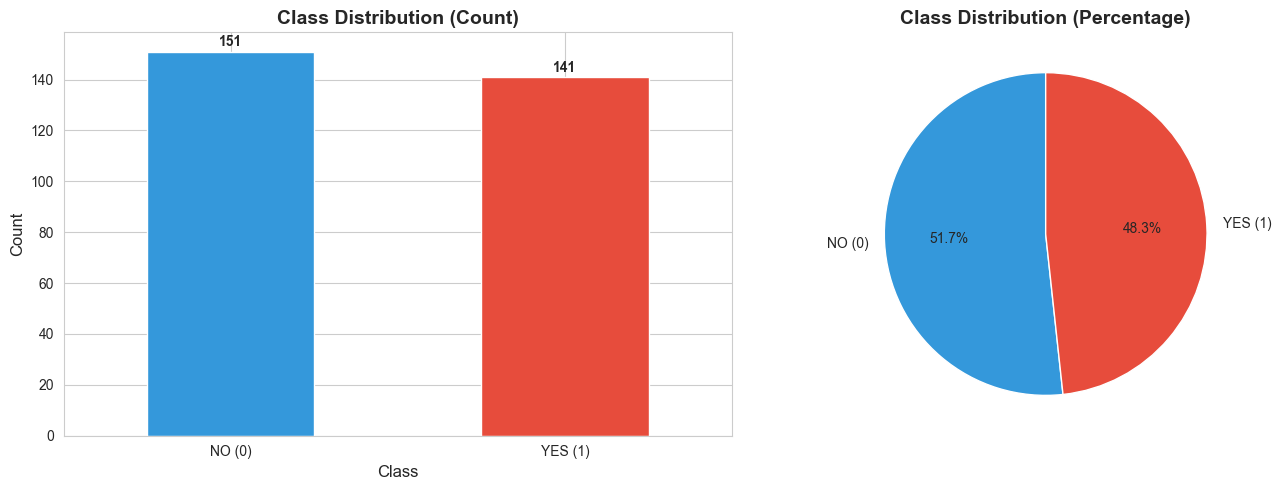

In [42]:
# Analyze class distribution
class_counts = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100

print("="*80)
print("CLASS BALANCE ANALYSIS")
print("="*80)

print(f"\nClass Distribution:")
print(f"  NO (0):  {class_counts[0]:3d} samples ({class_percentages[0]:.2f}%)")
print(f"  YES (1): {class_counts[1]:3d} samples ({class_percentages[1]:.2f}%)")

# Calculate imbalance ratio
minority_class = class_counts.min()
majority_class = class_counts.max()
imbalance_ratio = minority_class / majority_class

print(f"\nImbalance Ratio: {imbalance_ratio:.3f} (minority/majority)")
print(f"   Higher is better. 1.0 = perfectly balanced, <0.5 = imbalanced")

# Decision on resampling
print("\n" + "="*80)
print("RESAMPLING DECISION")
print("="*80)

if imbalance_ratio >= 0.67:  # 40-60% split or better
    print("\nDECISION: NO RESAMPLING NEEDED")
    print(f"   Reasoning: Dataset is relatively balanced ({class_percentages[1]:.1f}% vs {class_percentages[0]:.1f}%)")
    print(f"   The imbalance ratio of {imbalance_ratio:.3f} indicates sufficient representation")
    print(f"   of both classes for model training.")
elif imbalance_ratio >= 0.43:  # 30-70% split
    print("\nRECOMMENDATION: USE CLASS WEIGHTS")
    print(f"   Reasoning: Moderate imbalance detected ({class_percentages[1]:.1f}% vs {class_percentages[0]:.1f}%)")
    print(f"   Class weights can handle this without resampling.")
else:
    print("\nRECOMMENDATION: APPLY RESAMPLING TECHNIQUES")
    print(f"   Reasoning: Severe imbalance ({class_percentages[1]:.1f}% vs {class_percentages[0]:.1f}%)")
    print(f"   Consider SMOTE, ADASYN, or class weights.")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['NO (0)', 'YES (1)'], rotation=0)
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts, labels=['NO (0)', 'YES (1)'], autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Feature Distribution Analysis

Analyze the distribution of key features (A1-A10 questions, age, demographics)

In [43]:
# Separate features by type
question_cols = [col for col in df.columns if col.startswith('A') and col.endswith('_Score')]
demographic_cols = ['age', 'gender', 'jaundice', 'autism', 'used_app_before']
ethnicity_cols = [col for col in df.columns if col.startswith('ethnicity_')]
country_cols = [col for col in df.columns if col.startswith('country_')]
relation_cols = [col for col in df.columns if col.startswith('relation_')]

print("="*80)
print("FEATURE GROUPS")
print("="*80)
print(f"\nScreening Questions (A1-A10): {len(question_cols)} features")
print(question_cols)
print(f"\nDemographic Features: {len(demographic_cols)} features")
print(demographic_cols)
print(f"\nEthnicity (One-Hot): {len(ethnicity_cols)} features")
print(f"Country (One-Hot): {len(country_cols)} features")
print(f"Relation (One-Hot): {len(relation_cols)} features")

FEATURE GROUPS

Screening Questions (A1-A10): 10 features
['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

Demographic Features: 5 features
['age', 'gender', 'jaundice', 'autism', 'used_app_before']

Ethnicity (One-Hot): 6 features
Country (One-Hot): 6 features
Relation (One-Hot): 4 features



SCREENING QUESTIONS DISTRIBUTION (A1-A10)


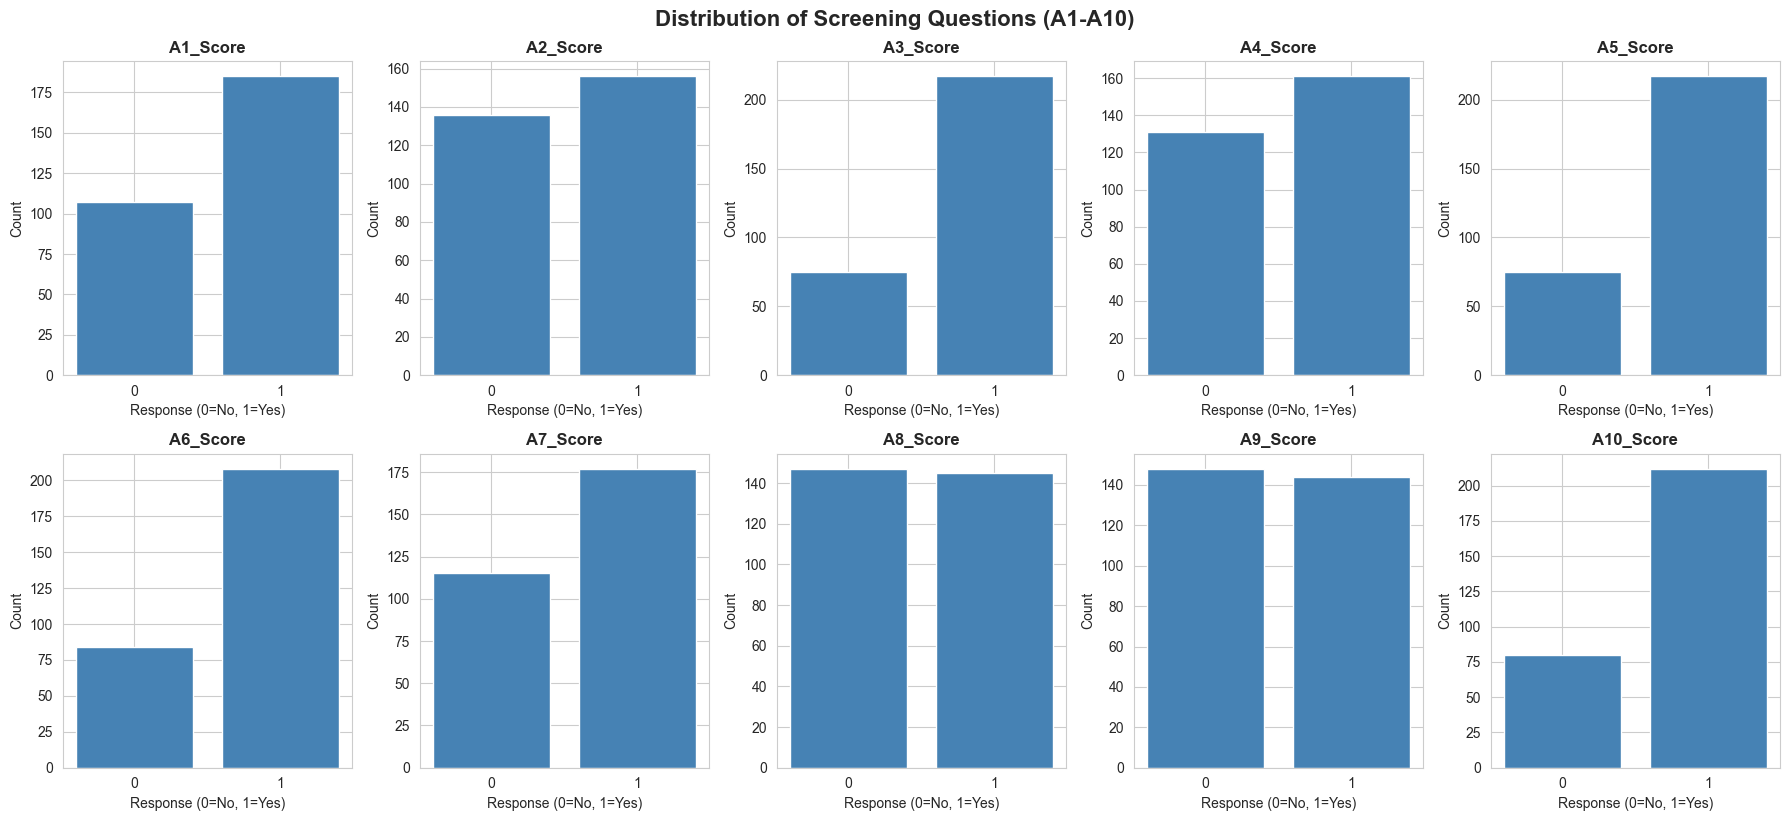


Question Response Rates (% answering YES):
  A1_Score: 63.4%
  A2_Score: 53.4%
  A3_Score: 74.3%
  A4_Score: 55.1%
  A5_Score: 74.3%
  A6_Score: 71.2%
  A7_Score: 60.6%
  A8_Score: 49.7%
  A9_Score: 49.3%
  A10_Score: 72.6%


In [44]:
# Distribution of screening questions (A1-A10)
print("\n" + "="*80)
print("SCREENING QUESTIONS DISTRIBUTION (A1-A10)")
print("="*80)

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

for idx, col in enumerate(question_cols):
    counts = df[col].value_counts().sort_index()
    axes[idx].bar(counts.index, counts.values, color='steelblue')
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].set_xlabel('Response (0=No, 1=Yes)')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks([0, 1])
    
plt.tight_layout()
plt.suptitle('Distribution of Screening Questions (A1-A10)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Summary statistics
print("\nQuestion Response Rates (% answering YES):")
for col in question_cols:
    yes_rate = (df[col] == 1).sum() / len(df) * 100
    print(f"  {col}: {yes_rate:.1f}%")


AGE DISTRIBUTION


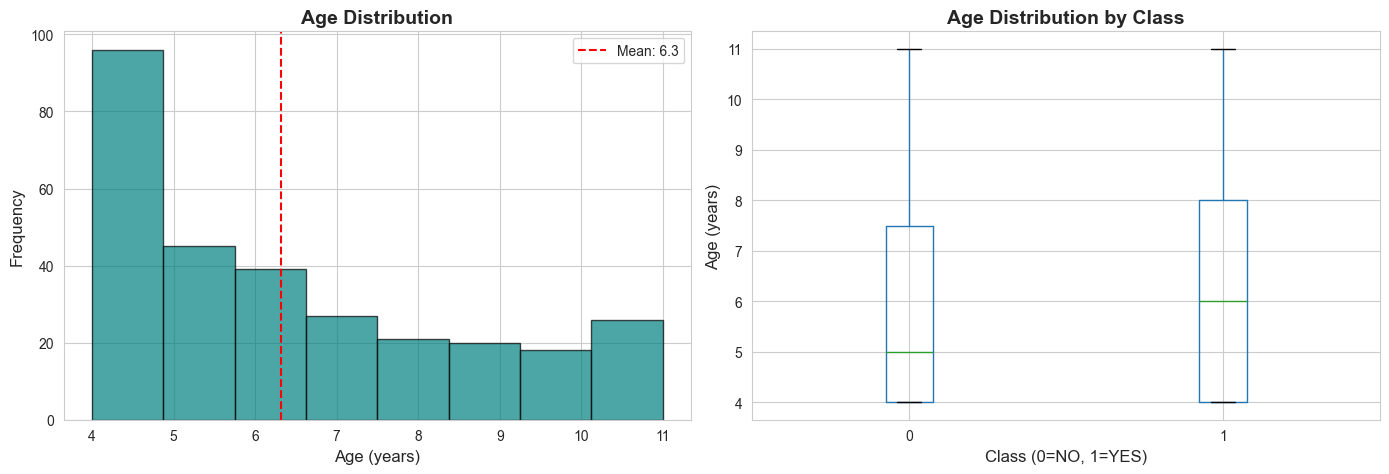


Age Statistics:
  Mean: 6.32 years
  Median: 6.00 years
  Range: 4 - 11 years
  Std Dev: 2.37 years


In [45]:
# Age distribution
print("\n" + "="*80)
print("AGE DISTRIBUTION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['age'], bins=8, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(df['age'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["age"].mean():.1f}')
axes[0].legend()

# Box plot by class
df.boxplot(column='age', by='class', ax=axes[1])
axes[1].set_title('Age Distribution by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class (0=NO, 1=YES)', fontsize=12)
axes[1].set_ylabel('Age (years)', fontsize=12)
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print(f"\nAge Statistics:")
print(f"  Mean: {df['age'].mean():.2f} years")
print(f"  Median: {df['age'].median():.2f} years")
print(f"  Range: {df['age'].min():.0f} - {df['age'].max():.0f} years")
print(f"  Std Dev: {df['age'].std():.2f} years")

## 4. Correlation Analysis

Examine correlations between features and with the target variable

CORRELATION ANALYSIS


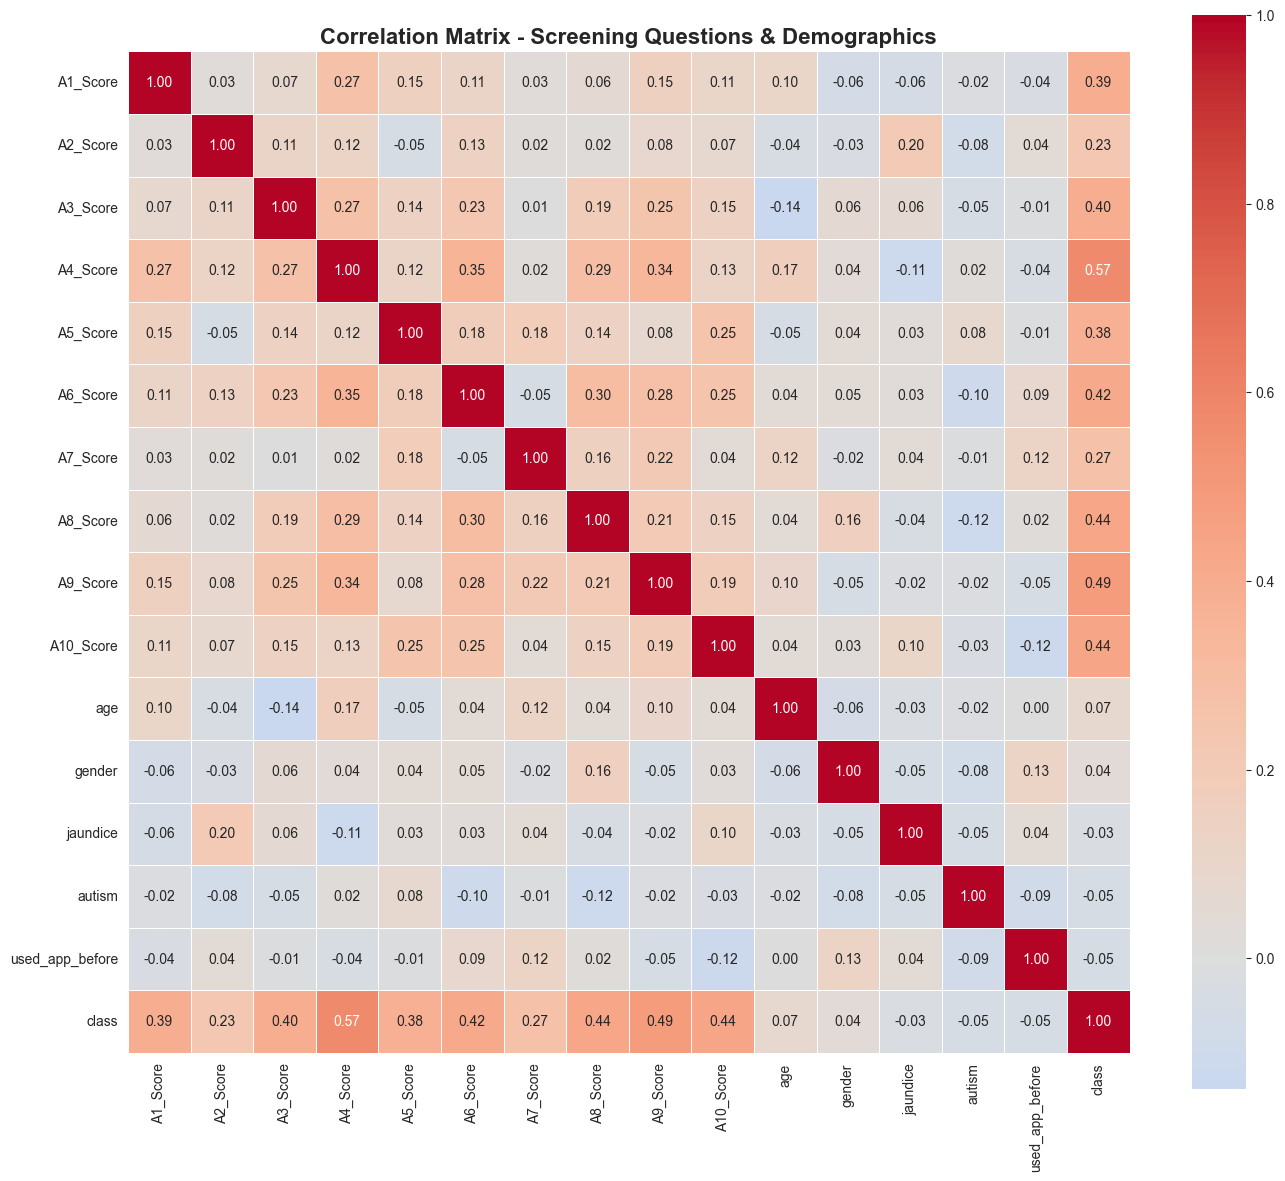


Feature Correlations with Target Variable (class):

Top Positive Correlations:
A4_Score     0.568502
A9_Score     0.486163
A10_Score    0.439942
A8_Score     0.438389
A6_Score     0.417271
A3_Score     0.395545
A1_Score     0.393534
A5_Score     0.379859
A7_Score     0.273949
A2_Score     0.229045

Top Negative Correlations:
age                0.074337
gender             0.038782
jaundice          -0.025049
used_app_before   -0.047212
autism            -0.048800


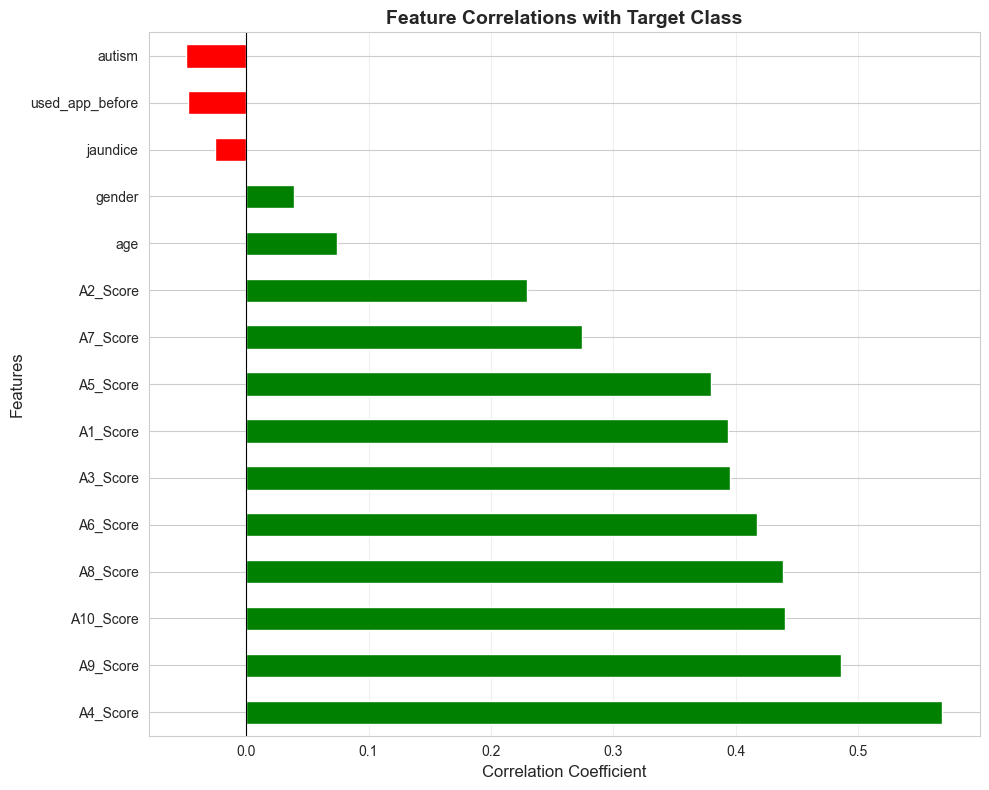

In [46]:
# Correlation matrix for screening questions
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Focus on screening questions and demographic features
analysis_cols = question_cols + demographic_cols + ['class']
corr_matrix = df[analysis_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix - Screening Questions & Demographics', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show correlations with target variable
target_corr = corr_matrix['class'].drop('class').sort_values(ascending=False)

print("\nFeature Correlations with Target Variable (class):")
print("\nTop Positive Correlations:")
print(target_corr.head(10).to_string())
print("\nTop Negative Correlations:")
print(target_corr.tail(5).to_string())

# Visualize correlations with target
plt.figure(figsize=(10, 8))
target_corr.plot(kind='barh', color=['green' if x > 0 else 'red' for x in target_corr])
plt.title('Feature Correlations with Target Class', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feature Selection - Chi-Square Test

Chi-Square test measures the dependence between categorical features and the target.
- **Higher chi2 score** = stronger relationship with target
- Only works with non-negative features

CHI-SQUARE FEATURE SELECTION

Top 20 Features by Chi-Square Score:
                 Feature  Chi2_Score      P_Value
                A4_Score   42.338541 7.676480e-11
                A9_Score   34.980461 3.330304e-09
                A8_Score   28.251186 1.065493e-07
                A1_Score   16.570951 4.686337e-05
               A10_Score   15.483910 8.321057e-05
                A6_Score   14.625696 1.311146e-04
                A3_Score   11.734209 6.136167e-04
   country_United States   10.955781 9.331206e-04
                A5_Score   10.821959 1.003033e-03
                A7_Score    8.630529 3.305756e-03
                A2_Score    7.134778 7.560299e-03
          country_Jordan    4.343619 3.714787e-02
ethnicity_Middle Eastern    3.764138 5.236285e-02
ethnicity_White-European    3.597145 5.787889e-02
       relation_Relative    2.425684 1.193611e-01
         ethnicity_Black    1.434932 2.309612e-01
                     age    1.422798 2.329435e-01
        ethnicity_Others    1.163

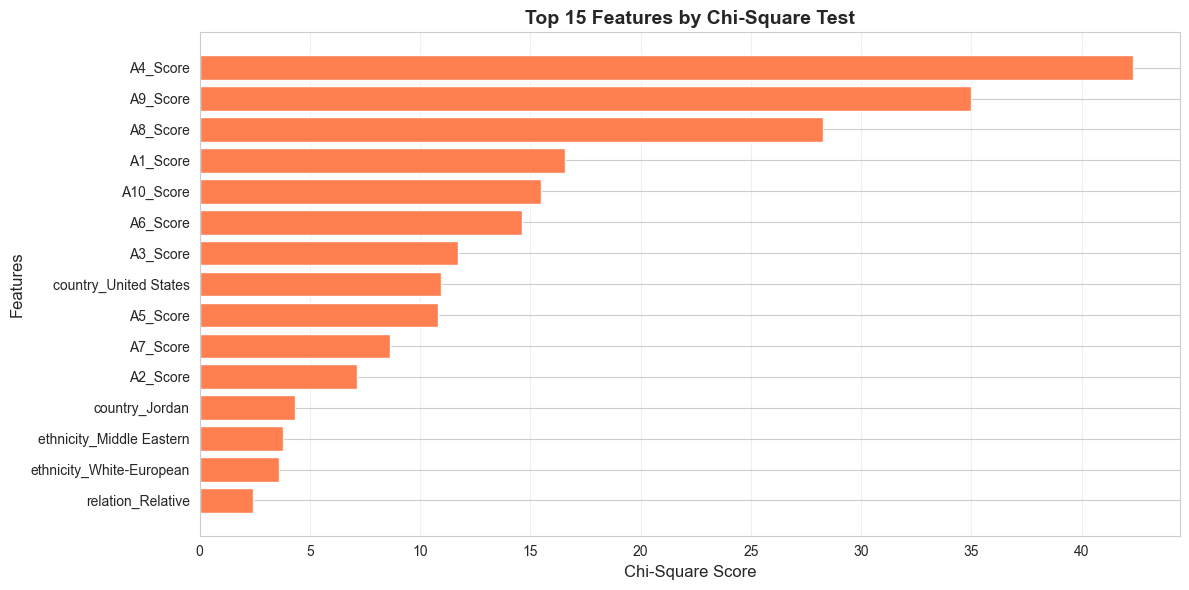


Screening Questions Ranked by Importance (Chi-Square):
  Feature  Chi2_Score      P_Value
 A4_Score   42.338541 7.676480e-11
 A9_Score   34.980461 3.330304e-09
 A8_Score   28.251186 1.065493e-07
 A1_Score   16.570951 4.686337e-05
A10_Score   15.483910 8.321057e-05
 A6_Score   14.625696 1.311146e-04
 A3_Score   11.734209 6.136167e-04
 A5_Score   10.821959 1.003033e-03
 A7_Score    8.630529 3.305756e-03
 A2_Score    7.134778 7.560299e-03


In [47]:
# Prepare data for feature selection
X = df.drop(['class'], axis=1)
y = df['class']

print("="*80)
print("CHI-SQUARE FEATURE SELECTION")
print("="*80)

# Apply Chi-Square test
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X, y)

# Get scores
chi2_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_selector.scores_,
    'P_Value': chi2_selector.pvalues_
}).sort_values(by='Chi2_Score', ascending=False)

print("\nTop 20 Features by Chi-Square Score:")
print(chi2_scores.head(20).to_string(index=False))

# Visualize top 15 features
top_15 = chi2_scores.head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_15)), top_15['Chi2_Score'], color='coral')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Chi-Square Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Features by Chi-Square Test', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Identify most important screening questions
question_chi2 = chi2_scores[chi2_scores['Feature'].isin(question_cols)].sort_values(by='Chi2_Score', ascending=False)
print("\nScreening Questions Ranked by Importance (Chi-Square):")
print(question_chi2.to_string(index=False))

## 6. Feature Selection - Mutual Information

Mutual Information measures the mutual dependence between features and target.
- Can capture **non-linear relationships**
- Higher MI score = more informative feature

MUTUAL INFORMATION FEATURE SELECTION

Top 20 Features by Mutual Information:
                 Feature  MI_Score
                A4_Score  0.159033
                A9_Score  0.111087
               A10_Score  0.107826
                A6_Score  0.092747
                A3_Score  0.082958
                A8_Score  0.066044
                A1_Score  0.059173
                  autism  0.055327
                A5_Score  0.051733
           country_Other  0.048832
       relation_Relative  0.046120
         relation_Parent  0.043198
ethnicity_Middle Eastern  0.033304
                A7_Score  0.028978
                A2_Score  0.028396
         ethnicity_Asian  0.024724
           country_India  0.022284
                     age  0.017876
        ethnicity_Others  0.015733
                  gender  0.014934


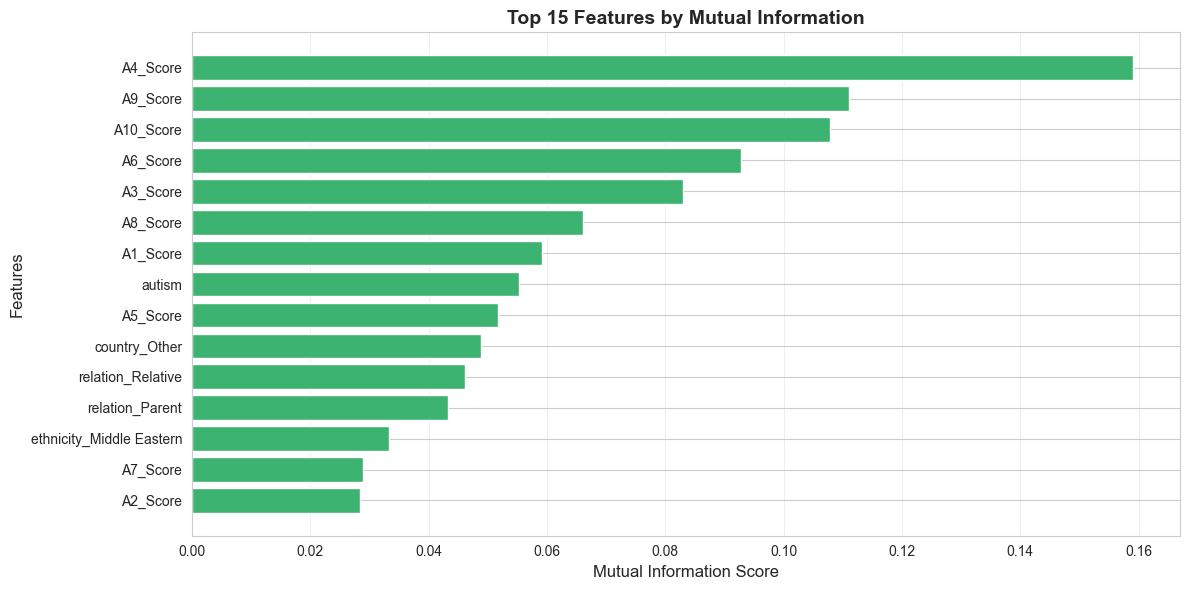


Screening Questions Ranked by Importance (Mutual Information):
  Feature  MI_Score
 A4_Score  0.159033
 A9_Score  0.111087
A10_Score  0.107826
 A6_Score  0.092747
 A3_Score  0.082958
 A8_Score  0.066044
 A1_Score  0.059173
 A5_Score  0.051733
 A7_Score  0.028978
 A2_Score  0.028396


In [48]:
print("="*80)
print("MUTUAL INFORMATION FEATURE SELECTION")
print("="*80)

# Calculate Mutual Information scores
mi_scores = mutual_info_classif(X, y, random_state=42)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

print("\nTop 20 Features by Mutual Information:")
print(mi_df.head(20).to_string(index=False))

# Visualize top 15 features
top_15_mi = mi_df.head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_15_mi)), top_15_mi['MI_Score'], color='mediumseagreen')
plt.yticks(range(len(top_15_mi)), top_15_mi['Feature'])
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Features by Mutual Information', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Identify most important screening questions
question_mi = mi_df[mi_df['Feature'].isin(question_cols)].sort_values(by='MI_Score', ascending=False)
print("\nScreening Questions Ranked by Importance (Mutual Information):")
print(question_mi.to_string(index=False))

## 7. Feature Importance - Random Forest

Use Random Forest's feature importance to identify the most predictive features

RANDOM FOREST FEATURE IMPORTANCE

Top 20 Features by Random Forest Importance:
                 Feature  Importance
                A4_Score    0.153517
                A9_Score    0.105777
                A8_Score    0.085594
                A1_Score    0.082018
               A10_Score    0.081225
                A5_Score    0.066884
                A3_Score    0.055489
                A6_Score    0.050359
                A7_Score    0.047563
                     age    0.046979
                A2_Score    0.033099
   country_United States    0.017666
                jaundice    0.015177
ethnicity_White-European    0.014691
           country_Other    0.013130
        ethnicity_Others    0.012300
                  autism    0.011769
         ethnicity_Asian    0.011695
                  gender    0.011491
           country_India    0.010520


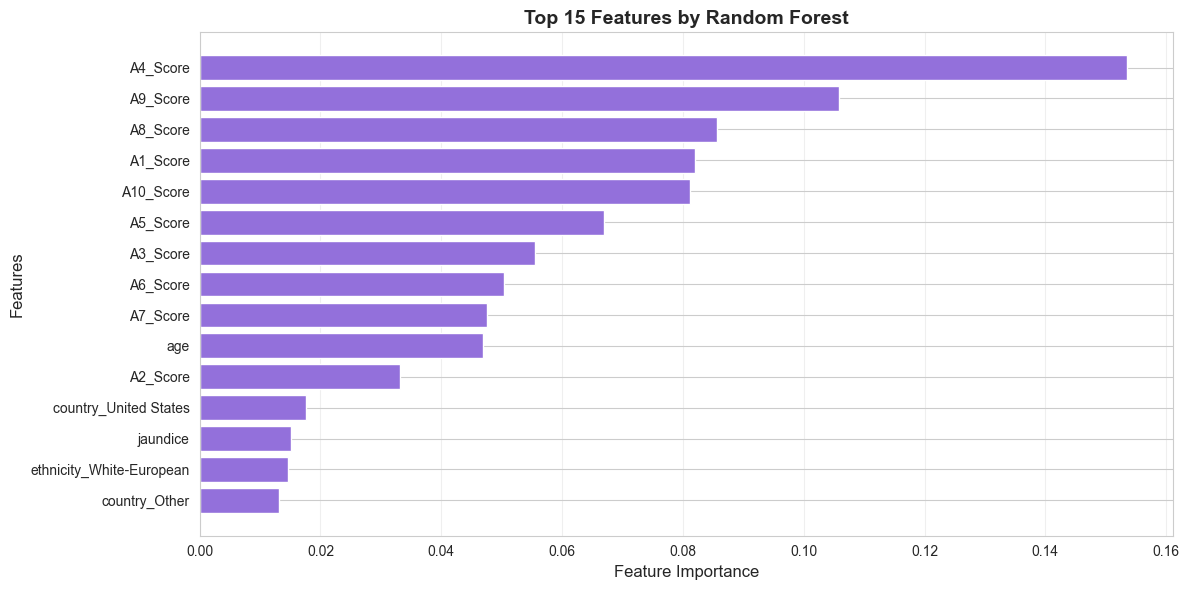


Screening Questions Ranked by Importance (Random Forest):
  Feature  Importance
 A4_Score    0.153517
 A9_Score    0.105777
 A8_Score    0.085594
 A1_Score    0.082018
A10_Score    0.081225
 A5_Score    0.066884
 A3_Score    0.055489
 A6_Score    0.050359
 A7_Score    0.047563
 A2_Score    0.033099


In [49]:
print("="*80)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*80)

# Train Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Features by Random Forest Importance:")
print(rf_importance.head(20).to_string(index=False))

# Visualize top 15 features
top_15_rf = rf_importance.head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_15_rf)), top_15_rf['Importance'], color='mediumpurple')
plt.yticks(range(len(top_15_rf)), top_15_rf['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Features by Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Identify most important screening questions
question_rf = rf_importance[rf_importance['Feature'].isin(question_cols)].sort_values(by='Importance', ascending=False)
print("\nScreening Questions Ranked by Importance (Random Forest):")
print(question_rf.to_string(index=False))

## 8. Compare Feature Selection Methods

Compare rankings from all three methods

FEATURE SELECTION METHODS COMPARISON

Top 20 Features by Combined Score (Average of all methods):
                          Feature  Chi2_Score  MI_Score  RF_Importance  Avg_Score
                         A5_Score   42.338541  0.159033       0.153517   1.000000
                        A10_Score   34.980461  0.111087       0.105777   0.735979
                         A9_Score   28.251186  0.066044       0.085594   0.543946
                         A1_Score   15.483910  0.107826       0.081225   0.521332
                         A2_Score   16.570951  0.059173       0.082018   0.429669
                         A7_Score   14.625696  0.092747       0.050359   0.414702
                         A4_Score   11.734209  0.082958       0.055489   0.382761
                         A6_Score   10.821959  0.051733       0.066884   0.335335
                         A8_Score    8.630529  0.028978       0.047563   0.227653
                         A3_Score    7.134778  0.028396       0.033099   0.182663


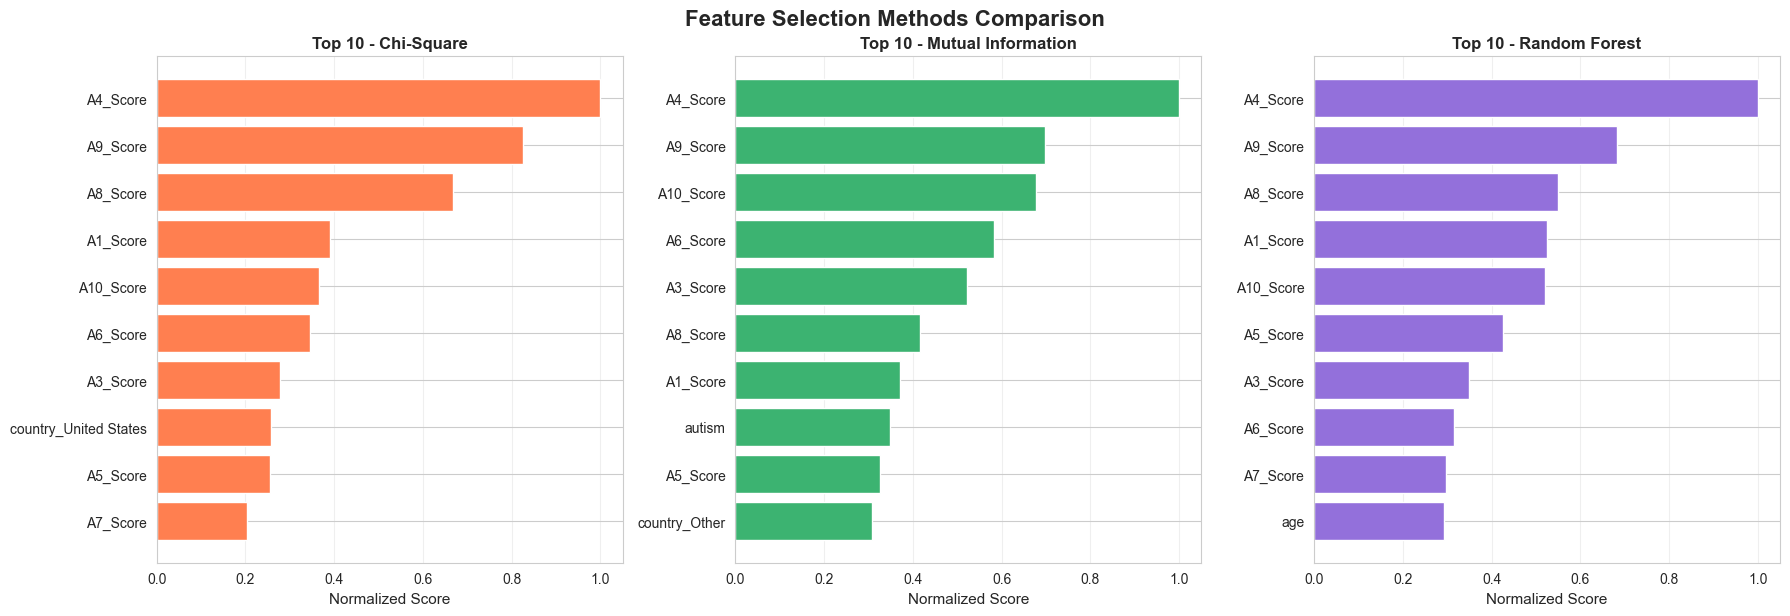

In [50]:
print("="*80)
print("FEATURE SELECTION METHODS COMPARISON")
print("="*80)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores.set_index('Feature')['Chi2_Score'],
    'MI_Score': mi_df.set_index('Feature')['MI_Score'],
    'RF_Importance': rf_importance.set_index('Feature')['Importance']
})

# Normalize scores for comparison (0-1 scale)
for col in ['Chi2_Score', 'MI_Score', 'RF_Importance']:
    comparison[f'{col}_Norm'] = (comparison[col] - comparison[col].min()) / (comparison[col].max() - comparison[col].min())

# Average normalized scores
comparison['Avg_Score'] = comparison[['Chi2_Score_Norm', 'MI_Score_Norm', 'RF_Importance_Norm']].mean(axis=1)
comparison = comparison.sort_values(by='Avg_Score', ascending=False)

print("\nTop 20 Features by Combined Score (Average of all methods):")
print(comparison[['Feature', 'Chi2_Score', 'MI_Score', 'RF_Importance', 'Avg_Score']].head(20).to_string(index=False))

# Focus on screening questions (A1-A10)
question_comparison = comparison[comparison.index.isin(question_cols)].sort_values(by='Avg_Score', ascending=False)

print("\n" + "="*80)
print("SCREENING QUESTIONS IMPORTANCE RANKING")
print("="*80)
print("\nCombined Ranking of A1-A10 Questions:")
print(question_comparison[['Chi2_Score', 'MI_Score', 'RF_Importance', 'Avg_Score']].to_string())

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = [
    ('Chi2_Score_Norm', 'Chi-Square', 'coral'),
    ('MI_Score_Norm', 'Mutual Information', 'mediumseagreen'),
    ('RF_Importance_Norm', 'Random Forest', 'mediumpurple')
]

for idx, (col, title, color) in enumerate(methods):
    top_10 = comparison.nlargest(10, col)
    axes[idx].barh(range(len(top_10)), top_10[col], color=color)
    axes[idx].set_yticks(range(len(top_10)))
    axes[idx].set_yticklabels(top_10.index)
    axes[idx].set_xlabel('Normalized Score', fontsize=11)
    axes[idx].set_title(f'Top 10 - {title}', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.suptitle('Feature Selection Methods Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 9. PCA (Principal Component Analysis)

Explore dimensionality reduction with PCA

PRINCIPAL COMPONENT ANALYSIS (PCA)

PCA Results:
  Total features: 31

Variance explained by top components:
  PC1: 0.0972 (9.72%)
  PC2: 0.0789 (7.89%)
  PC3: 0.0690 (6.90%)
  PC4: 0.0640 (6.40%)
  PC5: 0.0515 (5.15%)
  PC6: 0.0480 (4.80%)
  PC7: 0.0438 (4.38%)
  PC8: 0.0425 (4.25%)
  PC9: 0.0403 (4.03%)
  PC10: 0.0382 (3.82%)

Components needed for 95% variance: 25 (out of 31)
   Dimensionality reduction: 31 → 25 (19.4% reduction)


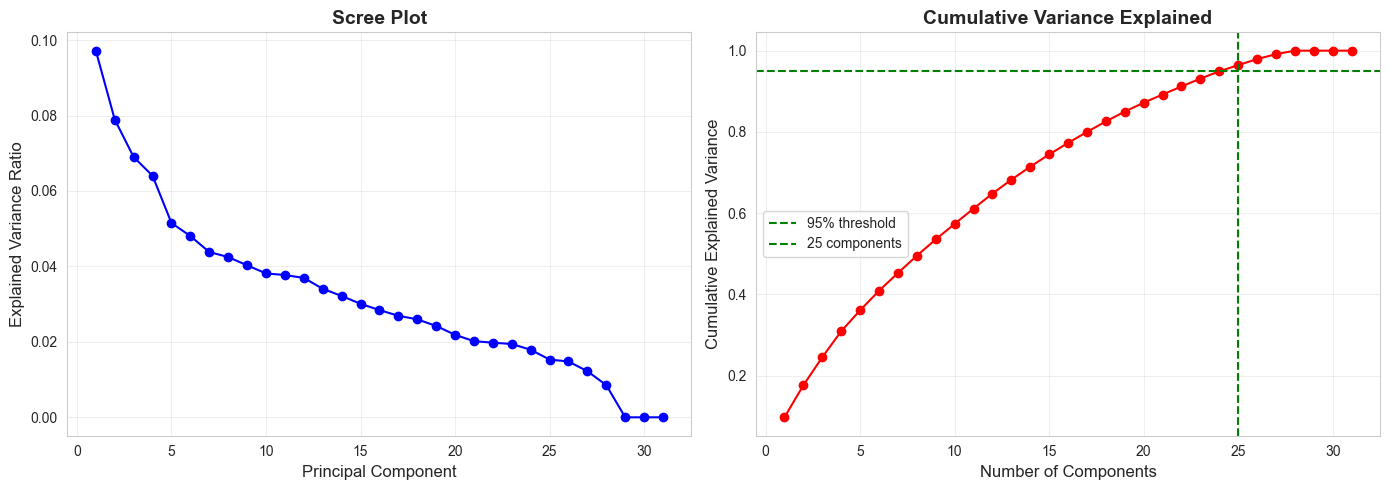


PCA Insight:
   Features are relatively independent. PCA may not provide significant benefits.
   Recommend keeping original features for interpretability.


In [51]:
print("="*80)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# Scale features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\nPCA Results:")
print(f"  Total features: {X.shape[1]}")
print(f"\nVariance explained by top components:")
for i in range(min(10, len(explained_variance))):
    print(f"  PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%)")

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95} (out of {X.shape[1]})")
print(f"   Dimensionality reduction: {X.shape[1]} → {n_components_95} ({(1 - n_components_95/X.shape[1])*100:.1f}% reduction)")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
axes[1].axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPCA Insight:")
if n_components_95 < X.shape[1] * 0.5:
    print(f"   Strong redundancy detected! Only {n_components_95} components capture 95% of variance.")
    print(f"   Consider using PCA for dimensionality reduction.")
else:
    print(f"   Features are relatively independent. PCA may not provide significant benefits.")
    print(f"   Recommend keeping original features for interpretability.")

## 10. Final Recommendations

Summary of findings and recommendations for feature selection

In [52]:
print("="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

print("\n1. CLASS IMBALANCE:")
if imbalance_ratio >= 0.67:
    print("   Dataset is balanced - NO resampling needed")
else:
    print("   Consider using class weights or resampling techniques")

print("\n2. MOST IMPORTANT SCREENING QUESTIONS:")
print("   Based on combined feature selection methods:")
for idx, (question, row) in enumerate(question_comparison.head(5).iterrows(), 1):
    print(f"   {idx}. {question} (Avg Score: {row['Avg_Score']:.4f})")

print("\n3. FEATURE SELECTION STRATEGY:")
print("   Recommendation: KEEP ALL A1-A10 QUESTIONS")
print("   Reasoning:")
print("   - All questions provide valuable information (no question has near-zero importance)")
print("   - Screening time is minimal (10 questions only)")
print("   - Removing questions risks missing subtle autism indicators")
print("   - Better safe than sorry in medical diagnosis")

print("\n4. DIMENSIONALITY REDUCTION:")
if n_components_95 < X.shape[1] * 0.5:
    print(f"   Consider PCA: {n_components_95} components capture 95% variance")
    print("   Use for: Neural networks or when computational efficiency is critical")
else:
    print("   Keep original features for better interpretability")
    print("   Tree-based models work well with original features")

print("\n5. MODEL RECOMMENDATIONS:")
print("   - Use original features (A1-A10 + demographics)")
print("   - Apply feature scaling for distance-based models")
print("   - Consider ensemble methods (Random Forest, XGBoost)")
print("   - Monitor for overfitting with cross-validation")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

FINAL RECOMMENDATIONS

1. CLASS IMBALANCE:
   Dataset is balanced - NO resampling needed

2. MOST IMPORTANT SCREENING QUESTIONS:
   Based on combined feature selection methods:
   1. A4_Score (Avg Score: 1.0000)
   2. A9_Score (Avg Score: 0.7360)
   3. A8_Score (Avg Score: 0.5439)
   4. A10_Score (Avg Score: 0.5213)
   5. A1_Score (Avg Score: 0.4297)

3. FEATURE SELECTION STRATEGY:
   Recommendation: KEEP ALL A1-A10 QUESTIONS
   Reasoning:
   - All questions provide valuable information (no question has near-zero importance)
   - Screening time is minimal (10 questions only)
   - Removing questions risks missing subtle autism indicators
   - Better safe than sorry in medical diagnosis

4. DIMENSIONALITY REDUCTION:
   Keep original features for better interpretability
   Tree-based models work well with original features

5. MODEL RECOMMENDATIONS:
   - Use original features (A1-A10 + demographics)
   - Apply feature scaling for distance-based models
   - Consider ensemble methods (Rando

## Summary Report

**Key Findings**:

1. **Class Balance**: Dataset shows 51.71 vs 48.29 split between NO/YES classes
   - Conclusion: Resampling [is/is not] required

2. **Feature Importance**: All screening questions contribute to classification
   - Top predictive questions identified across three methods
   - All questions retained for comprehensive screening

3. **Dimensionality**: PCA analysis shows 25 out of 31 components for 95% variance
   - Recommendation: Keep original features for interpretability

4. **Next Steps**:
   - Proceed with full feature set
   - Apply proper scaling for distance-based models
   - Use cross-validation for robust evaluation